In [129]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib
import matplotlib.pyplot as plt

# Alleen train inladen
train_path = "../../data/data_train.csv" 
df = pd.read_csv(train_path, sep=",", decimal=".")

In [130]:
# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape


((1995, 9), (1995,))

In [131]:
# Er is maar een categorische variabelen waar we OneHotEncoder op kunnen gebruiken namelijk Age group, 
# ookal is dit eigenlijk niet nodig omdat we ook een numerieke Age variabelen in de dataset hebben, maar de opdracht zei dat het moest...
cat_cols = ["Age Group"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [132]:
# ColumnTransformer voor OneHotEncoder en StandardScaler voor de overige numerieke variabelen
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [133]:
# Hier maken we de pipline aan 
prep_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])
prep_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse m

In [134]:
# Hier stoppen we X (input variabelen) in onze pipeline en leert de pipeline hoe hij deze moet schalen/encoden
X_prepared = prep_pipeline.fit_transform(X)
X_prepared.shape

(1995, 13)

We hebben nu 13 kolommen omdat door OneHotEncoder de categorische Age is omgezet naar 5 binaire kolommen.

In [135]:
# Fase 4: Nu voegen we Logistic Regression toe aan onze pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(random_state=2026))
])

model_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [136]:
# Fit het model
model_pipeline.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers c

In [137]:
# De pipeline opslaan als bestand
joblib.dump(model_pipeline, "../../data/model_pipeline.joblib")
# Model weer inladen:
# model_pipeline = joblib.load("../../data/model_pipeline.joblib")

['../../data/model_pipeline.joblib']

Nu hebben we het modelleren afgerond.
De volgende stap is ons model beoordelen op de trainingsdata

In [138]:
# Voorspel de kans op Churn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

y_pred = model_pipeline.predict(X)
y_prob = model_pipeline.predict_proba(X)[:,1]  # kans dat Churn = 1

In [287]:
# Winstvergelijkingen
W1 = 0.1 * X["Frequency of SMS"] + 0.3 * X["Seconds of Use"]
W2 = 0.07 * X["Frequency of SMS"] + 0.2 * X["Seconds of Use"]

# Balansvergelijking
df['thresholds'] = (W1-W2)/(W1-(W2*0.75))

df['thresholds']

0       0.664935
1       0.666459
2       0.666311
3       0.666657
4       0.666648
          ...   
1990    0.666481
1991    0.666627
1992    0.666449
1993    0.666449
1994    0.666667
Name: thresholds, Length: 1995, dtype: float64

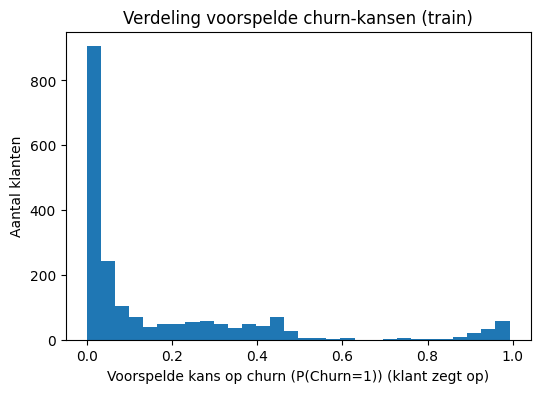

In [ ]:
# Verdeling voorspelde kans op churn
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=30)
plt.title("Verdeling voorspelde churn-kansen (train)")
plt.xlabel("Voorspelde kans op churn (P(Churn=1)) (klant zegt op)")
plt.ylabel("Aantal klanten")
plt.show()

In [289]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.05, 0.95, 19)

precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    precisions.append(precision_score(y, y_pred_t, zero_division=0))
    recalls.append(recall_score(y, y_pred_t))
    f1s.append(f1_score(y, y_pred_t))

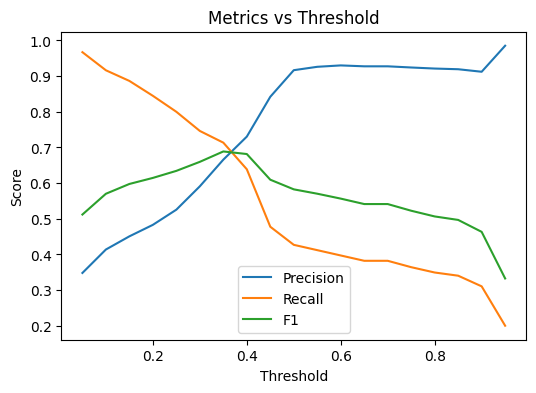

In [ ]:
# Plotten scores en thresholds
plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs Threshold")
plt.legend()
plt.show()

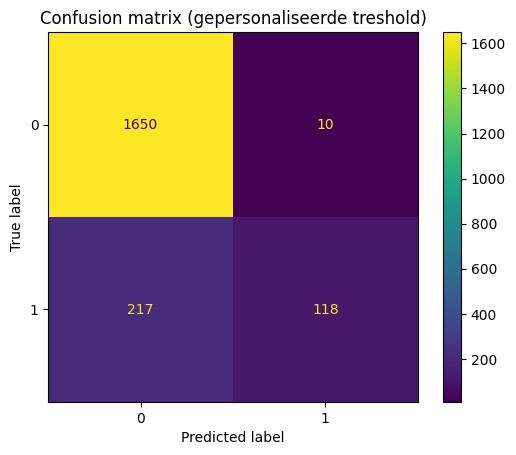

In [300]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_05 = (y_prob >= df['thresholds']).astype(int)

cm = confusion_matrix(y, y_pred_05)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion matrix (gepersonaliseerde treshold)")
plt.show()

In [301]:
E1 = (1 - y_pred_05) * W1
E2 = (1 - 0.75 * y_pred_05) * W2

offer_tarief2 = (E2 > E1).astype(int)

# Toevoegen aan dataframe
df["Voorspelde_kans_churn"] = y_pred_05
df["Tarief2_aanbieden"] = offer_tarief2

# Hoeveel klanten krijgen tarief 2
aantal_tarief2 = offer_tarief2.sum()
print("Aantal klanten tarief 2:", aantal_tarief2)

Aantal klanten tarief 2: 128


In [302]:
# p = kans op churn (vertrekken)
p = y_pred_05  # dit is P(Churn=1)

# Zet data om naar per maand (dataset is vaak totaal over 9 maanden)
sms_pm = X["Frequency of SMS"] / 9
min_pm = (X["Seconds of Use"] / 60) / 9   # seconden -> minuten -> per maand

# Verwachte winst per maand
E_tarief2 = (1 - 0.75 * p) * W2
E_tarief1 = (1 - p) * W1

# Beslissen wie tarief 2 krijgt (winst-gedreven)
offer_tarief2 = (E_tarief2 > E_tarief1).astype(int)

# Totale verwachte maandelijkse winst met deze strategie
totale_winst = E_tarief2[offer_tarief2 == 1].sum() + E_tarief1[offer_tarief2 == 0].sum()

print("Aantal klanten tarief 2:", int(offer_tarief2.sum()))
print("Totale verwachte maandelijkse winst:", round(float(totale_winst), 2))

# Baselines ter vergelijking
print("Winst als altijd tarief 1:", round(float(E_tarief1.sum()), 2))
print("Winst als altijd tarief 2:", round(float(E_tarief2.sum()), 2))

Aantal klanten tarief 2: 128
Totale verwachte maandelijkse winst: 6415.74
Winst als altijd tarief 1: 6384.38
Winst als altijd tarief 2: 4340.85


De winst is iets hoger dan wanneer we iedereen tarief 1 aanbieden, maar het verschil is klein (ongeveer €22 per maand). Dit betekent dat het goedkopere tarief maar voor een kleine groep klanten echt voordelig is. Het model vindt dus een kleine groep klanten waarbij tarief 2 nét iets meer winst oplevert.

In [303]:
# Vergelijken met dummy model
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=2026)
dummy.fit(X, y)
proba_dummy = dummy.predict_proba(X)[:, 1]

sms_pm = X["Frequency of SMS"] / 9
min_pm = (X["Seconds of Use"] / 60) / 9

W1 = 0.1 * sms_pm + 0.3 * min_pm
W2 = 0.07 * sms_pm + 0.2 * min_pm

def profit_from_probs(p):
    E1 = (1 - p) * W1
    E2 = (1 - 0.75 * p) * W2
    offer = (E2 > E1).astype(int)
    total = E2[offer==1].sum() + E1[offer==0].sum()
    return float(total), int(offer.sum())

profit_model, n_offer_model = profit_from_probs(y_pred_05)
profit_dummy, n_offer_dummy = profit_from_probs(proba_dummy)

print("MODEL: winst =", round(profit_model, 2), ": tarief2 aan", n_offer_model)
print("DUMMY: winst =", round(profit_dummy, 2), ": tarief2 aan", n_offer_dummy)


MODEL: winst = 6415.74 : tarief2 aan 128
DUMMY: winst = 6571.17 : tarief2 aan 0
